In [1]:
"""
Purpose: To check the level 2 version of Peters rule
This version says that if axon projecting into region R has certain proportion of contacts
The number of synapses should be equal to that proportion of contacts

Strategy (for comparing compartments): 
Presteps: 
a) Get the contact conversion rate of the whole volume for all dendrite, basal, apical, oblique
b) Get the contact conversion for dendrites

1) For each neurite, get a distribution its contacts and the distribution of its synapses

For the weighted version:
2) From the contacts compute a an expected synapses (based on either the contact conversion for all dendrites or individual group conversion)
3) take the difference
4) Represent this as a distribution/vector
5) Combine all of them and see if deviates from Peter's rule

For the unweight version:
2) Normalize the number of contacts and the number of synapses
3) Take the difference
4) Represent this as a distribution/vector
5) Combine all of them and see if deviates from Peter's rule




Things to consider: 
1) Exclude axon and soma synapsing
"""

"\nPurpose: To check the level 2 version of Peters rule\nThis version says that if axon projecting into region R has certain proportion of contacts\nThe number of synapses should be equal to that proportion of contacts\n\nStrategy (for comparing compartments): \nPresteps: \na) Get the contact conversion rate of the whole volume for all dendrite, basal, apical, oblique\nb) Get the contact conversion for dendrites\n\n1) For each neurite, get a distribution its contacts and the distribution of its synapses\n\nFor the weighted version:\n2) From the contacts compute a an expected synapses (based on either the contact conversion for all dendrites or individual group conversion)\n3) take the difference\n4) Represent this as a distribution/vector\n5) Combine all of them and see if deviates from Peter's rule\n\nFor the unweight version:\n2) Normalize the number of contacts and the number of synapses\n3) Take the difference\n4) Represent this as a distribution/vector\n5) Combine all of them and 

In [18]:
compartment_names = ["Apical","Basal","Oblique","Dendrite"]
def print_stats(groups,stat_title,stat_values):
    for gr,st_val in zip(groups,stat_values):
        print(f"{gr} {stat_title} = {st_val}")

In [3]:
import datajoint as dj
import numpy as np
import time

import pandas as pd
import seaborn as sns
sns.set() #sets the asethetics parameters in what set

#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20

schema = dj.schema('microns_pinky')
pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_fc = dj.create_virtual_module("pinky_fc","microns_pinky_fc")

Connecting celiib@10.28.0.34:3306


In [4]:
# For each Neurite get the number of synapses and it's contact length
neurite_synapses_greater_6 = (pinky.NeuriteTargetsRevised.proj("apical_num","basal_num","oblique_num","dendrite_num","total")
                                                  & "apical_num + basal_num + oblique_num + dendrite_num>6")
neurite_contacts_greater_6 = pinky_fc.NeuriteContact.proj("apical_postsyn_length",
                        "basal_postsyn_length",
                       "oblique_postsyn_length",
                        "dendrites_postsyn_length"
                       ) & neurite_synapses_greater_6.proj()

neurite_synapses_greater_6 = neurite_synapses_greater_6 & neurite_contacts_greater_6.proj()

In [5]:
# neurite_contacts_greater_6 = pinky_fc.NeuriteContact() & neurite_synapses_greater_6.proj()

# Try to get the total contact conversion in the volume overall and for these neurons

In [6]:
#find the total conversions
total_neurite_synapses = pinky.NeuriteTargetsRevised.proj("apical_num","basal_num","oblique_num","dendrite_num")
total_neurite_contacts = pinky_fc.NeuriteContact.proj("apical_postsyn_length",
                        "basal_postsyn_length",
                       "oblique_postsyn_length",
                        "dendrites_postsyn_length"
                       )

#fetch the total apical, basal,dendrite and oblique synapse number
total_synapses = dj.U("segmentation").aggr(pinky.NeuriteTargetsRevised,
                          apical_num="SUM(apical_num)",
                          basal_num="SUM(basal_num)",
                          oblique_num="SUM(oblique_num)",
                          dendrite_num="SUM(dendrite_num)")
total_synapse_count = total_synapses.fetch()
total_synapse_count = np.array(list(total_synapse_count[0]))[1:]
print("Apical,Basal,Oblique,Dendrite synapse number = " + str(total_synapse_count))

#fetch the total apical, basal,dendrite and oblique contact length
total_contacts = dj.U("segmentation").aggr(pinky_fc.NeuriteContact,
                          apical_num="SUM(apical_postsyn_length)",
                          basal_num="SUM(basal_postsyn_length)",
                          oblique_num="SUM(oblique_postsyn_length)",
                          dendrite_num="SUM(dendrites_postsyn_length)")

total_contacts_count = total_contacts.fetch()
total_contacts_count = np.array(list(total_contacts_count[0]))[1:]
total_contacts_count = total_contacts_count.astype("float64")
print("Apical,Basal,Oblique,Dendrite contacts number = " + str(total_contacts_count))

#get the overall contact conversion and the contact conversion for compartments
total_contact_conversion = np.sum(total_synapse_count)/np.sum(total_contacts_count)
print("total_contact_conversion = %f" % (total_contact_conversion))
compartment_names = ["Apical","Basal","Oblique","Dendrite"]
for i,comp_name in enumerate(compartment_names):
    print(f"{comp_name} contact conversion = %f" % (total_synapse_count[i]/total_contacts_count[i]))

Apical,Basal,Oblique,Dendrite synapse number = [ 22469. 100509.  16002.  57261.]
Apical,Basal,Oblique,Dendrite contacts number = [3.64016780e+09 2.21621565e+10 2.59160794e+09 4.42717138e+09]
total_contact_conversion = 0.000006
Apical contact conversion = 0.000006
Basal contact conversion = 0.000005
Oblique contact conversion = 0.000006
Dendrite contact conversion = 0.000013


In [7]:
#for conversions on only those with greater than 6 synapses
#find the total conversions

#fetch the total apical, basal,dendrite and oblique synapse number
total_synapses = dj.U("segmentation").aggr(pinky.NeuriteTargetsRevised & neurite_contacts_greater_6.proj(),
                          apical_num="SUM(apical_num)",
                          basal_num="SUM(basal_num)",
                          oblique_num="SUM(oblique_num)",
                          dendrite_num="SUM(dendrite_num)")
total_synapse_count = total_synapses.fetch()
total_synapse_count = np.array(list(total_synapse_count[0]))[1:]
print("Apical,Basal,Oblique,Dendrite synapse number = " + str(total_synapse_count))

#fetch the total apical, basal,dendrite and oblique synapse number
total_contacts = dj.U("segmentation").aggr(pinky_fc.NeuriteContact  & neurite_contacts_greater_6.proj(),
                          apical_num="SUM(apical_postsyn_length)",
                          basal_num="SUM(basal_postsyn_length)",
                          oblique_num="SUM(oblique_postsyn_length)",
                          dendrite_num="SUM(dendrites_postsyn_length)")

total_contacts_count = total_contacts.fetch()
total_contacts_count = np.array(list(total_contacts_count[0]))[1:]
total_contacts_count = total_contacts_count.astype("float64")
print("Apical,Basal,Oblique,Dendrite contacts number = " + str(total_contacts_count))

#get the overall contact conversion and the contact conversion for compartments
total_contact_conversion = np.sum(total_synapse_count)/np.sum(total_contacts_count)
print("total_contact_conversion = %f" % (total_contact_conversion))

compartment_contact_conversion = []
for i,comp_name in enumerate(compartment_names):
    compartment_contact_conversion.append(total_synapse_count[i]/total_contacts_count[i])
    print(f"{comp_name} contact conversion = %f" % (total_synapse_count[i]/total_contacts_count[i]))

Apical,Basal,Oblique,Dendrite synapse number = [11849. 55879.  9074. 30515.]
Apical,Basal,Oblique,Dendrite contacts number = [1.68534134e+09 1.06383969e+10 1.27190494e+09 2.12629375e+09]
total_contact_conversion = 0.000007
Apical contact conversion = 0.000007
Basal contact conversion = 0.000005
Oblique contact conversion = 0.000007
Dendrite contact conversion = 0.000014


# Conclusion: Conversions are about the same but have 2-3 higher conversion on dendrites than others

In [8]:

contact_data = np.asarray(neurite_contacts_greater_6.fetch("apical_postsyn_length",
                                                          "basal_postsyn_length",
                                                           "oblique_postsyn_length",
                                                           "dendrites_postsyn_length"
                                                           )).T
contact_data

synapse_data = np.asarray(neurite_synapses_greater_6.fetch("apical_num",
                                            "basal_num",
                                            "oblique_num",
                                           "dendrite_num")).T
synapse_data




array([[ 1.,  5.,  1.,  1.],
       [ 0.,  9.,  0.,  1.],
       [ 0.,  5.,  0.,  2.],
       ...,
       [ 0.,  6.,  2.,  0.],
       [ 2.,  1.,  4.,  0.],
       [ 0., 10.,  1.,  1.]])

# Using dendritic specific conversion rate

In [9]:
synapse_sum = np.sum(synapse_data,axis=1)
np.where(synapse_sum<=0)

(array([], dtype=int64),)

In [10]:
""" Using a dendrite specific / non-normalized 
method of predicting the number of synapses from the contacts
"""

' Using a dendrite specific / non-normalized \nmethod of predicting the number of synapses from the contacts\n'

In [11]:
#predict the number of synapses based on the dendrite specific conversion rate
synapse_predictions = contact_data*np.array(compartment_contact_conversion)

#find the differences between the prediction and the actual
synapse_prediction_error = synapse_predictions - synapse_data
synapse_prediction_error

array([[-0.03620701, -1.30410291, -0.32841674, -0.09004384],
       [ 0.03966678, -4.67808501,  0.63235953,  2.17326508],
       [ 0.        , -1.8263719 ,  0.2269811 , -1.15692073],
       ...,
       [ 0.18574204,  0.01933781, -1.32032658,  1.64726663],
       [-0.6677672 ,  4.25360136, -3.41713028,  1.3690387 ],
       [ 0.83368427, -0.52386767,  0.78721221,  1.5079262 ]])

In [12]:
"""---------------- Computes the overall vector ---------------"""

sum_of_errors = np.sum(synapse_prediction_error,axis=0)
#np.set_printoptions(precision=15)
np.set_printoptions(suppress=True)
print(sum_of_errors)

[-0. -0.  0. -0.]


# Using NON-dendritic conversion rate

In [13]:
""" Using a NON-dendrite specific / non-normalized 
method of predicting the number of synapses from the contacts
"""
#predict the number of synapses based on the dendrite specific conversion rate
synapse_predictions_total = contact_data*np.array(total_contact_conversion)

#find the differences between the prediction and the actual
synapse_prediction_error_total = synapse_predictions_total - synapse_data
synapse_prediction_error_total

array([[-0.064266  , -0.19702962, -0.3574333 , -0.56719444],
       [ 0.03851195, -3.3834936 ,  0.60503768,  0.50931092],
       [ 0.        , -0.87573968,  0.21717411, -1.59900332],
       ...,
       [ 0.18033451,  1.82237721, -1.34969268,  0.78349506],
       [-0.70655261,  5.82727118, -3.44231387,  0.65116056],
       [ 0.80941315,  2.31462396,  0.70999356,  0.19285351]])

In [14]:
"""   ---------------- Computes the overall vector --------------- """

sum_of_errors_total = np.sum(synapse_prediction_error_total,axis=0)
#np.set_printoptions(precision=15)
np.set_printoptions(suppress=True)
print("Error Synapse Vector [Apical,Basal,Oblique,Dendrite]")
print(sum_of_errors_total/len(contact_data))

Error Synapse Vector [Apical,Basal,Oblique,Dendrite]
[-0.03166522  1.53644761 -0.03598798 -1.4687944 ]


# Normalized Method

In [24]:
""" Using a normalized method of predicting the number of synapses from the contacts
"""

#need to rerun: 

contact_data_normalized = contact_data/np.sum(contact_data,1).reshape(-1,1)
synapse_data_normalized = synapse_data/np.sum(synapse_data,1).reshape(-1,1)
#find the differences between the prediction and the actual
synapse_prediction_error_normalized = synapse_data_normalized - contact_data_normalized 



In [ ]:
'''
mean and standard deviation
histogram plot (looking for bell shaped curve)
QQplots (background):
p-value test: D'Agostinos K^2 test (why use): because it quantifies the
a. Skew: How much distribution is pushed left or right (measure of asymmetry
b. Kurtosis: How much of distribution is in the tail
 
'''

In [25]:
#check mean and standard deviation for each
mean_errors = np.mean(synapse_prediction_error_normalized,axis=0)
print_stats(compartment_names,"Mean of error",mean_errors)
print("---------------------")
std_errors = np.std(synapse_prediction_error_normalized,axis=0)
print_stats(compartment_names,"Std deviation of error",std_errors)

Apical Mean of error = -0.010878721872964821
Basal Mean of error = 0.16076173787626674
Oblique Mean of error = -0.003152219595169679
Dendrite Mean of error = -0.14673079640813225
---------------------
Apical Std deviation of error = 0.11631801250148961
Basal Std deviation of error = 0.1917213747914263
Oblique Std deviation of error = 0.09744648967402739
Dendrite Std deviation of error = 0.18109855152867368


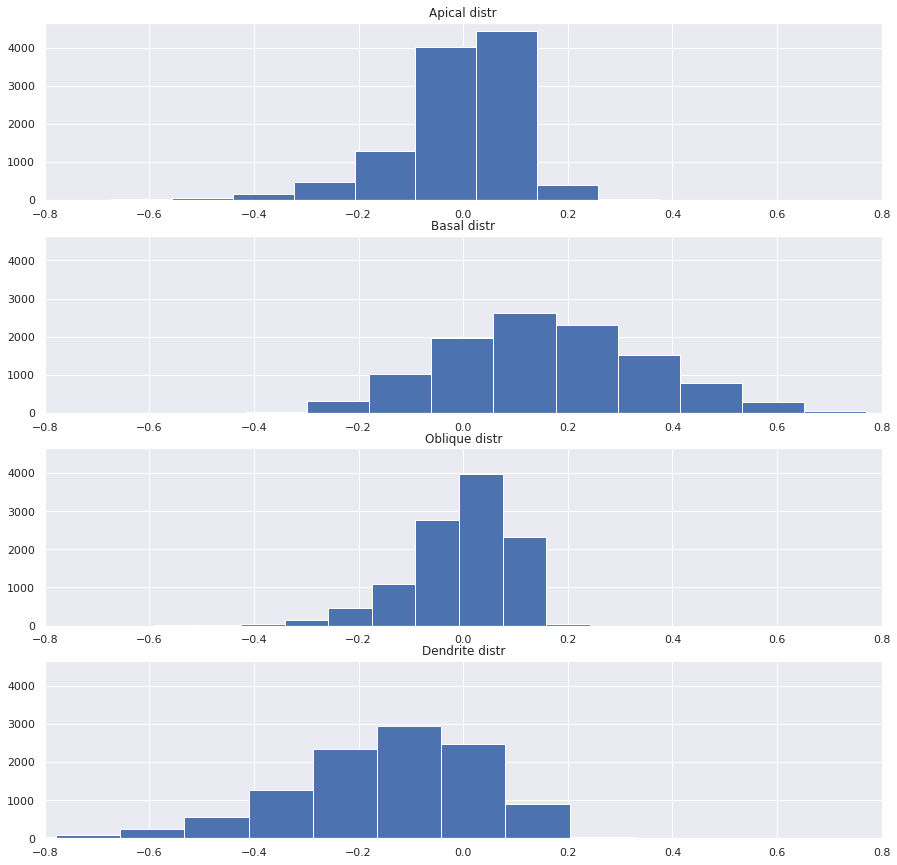

In [37]:
#get histograms of all the marginals
from matplotlib import pyplot as plt

# Creates two subplots and unpacks the output array immediately
f, axes = plt.subplots(4, 1, sharey=True,figsize=(15,15))

for ax,column_data,comp_name in zip(axes,synapse_prediction_error_normalized.T,compartment_names):
    ax.hist(column_data)
    ax.set_title(comp_name + " distr")
    ax.set_xlim([-0.8,0.8])

In [ ]:
#check how well each of them fit a gaussian distribution

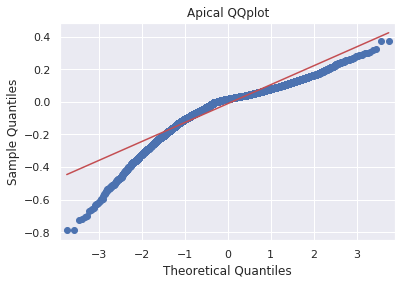

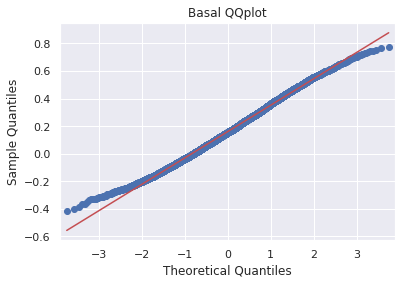

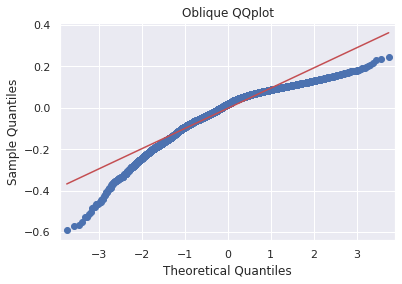

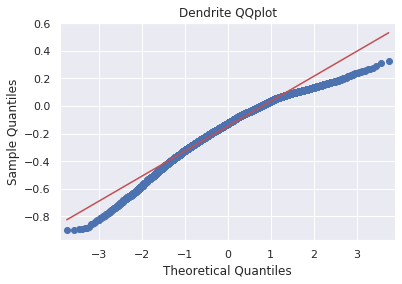

In [48]:
from statsmodels.graphics.gofplots import qqplot
for ax,column_data,comp_name in zip(axes,synapse_prediction_error_normalized.T,compartment_names):
    qqplot(column_data, line='s',fit=False)
    pyplot.title(str(comp_name) + " QQplot")
    plt.show()


In [50]:
# D'Agostino and Pearson's Test (demonstrating that it works)
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.102, p=0.950
Sample looks Gaussian (fail to reject H0)


In [51]:
from scipy.stats import normaltest

"""
Statistic returned is 
s^2 + k^2, where s is the z-score returned by skewtest and 
k is the z-score returned by kurtosistest
"""

from statsmodels.graphics.gofplots import qqplot
for column_data,comp_name in zip(synapse_prediction_error_normalized.T,compartment_names):
    stat, p = normaltest(column_data)
    print(comp_name + ' Statistics=%.3f, p=%.7f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('     Sample looks Gaussian (fail to reject H0)')
    else:
        print('     Sample does not look Gaussian (reject H0)')


Apical Statistics=3168.782, p=0.0000000
     Sample does not look Gaussian (reject H0)
Basal Statistics=107.053, p=0.0000000
     Sample does not look Gaussian (reject H0)
Oblique Statistics=2008.667, p=0.0000000
     Sample does not look Gaussian (reject H0)
Dendrite Statistics=793.197, p=0.0000000
     Sample does not look Gaussian (reject H0)


In [ ]:
"K-divergence measurement"

# ! Doing the Same Analysis for Neurons of Different Orientation ! #

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


In [54]:
pinky.SynapseSpineLabelFinalThresholdRevised()

segmentation segmentation id,synapse_id synapse index within the segmentation,spine_label numeric label of the compartment
3,3,13
3,5,13
3,22,13
3,25,13
3,30,13
3,41,13
3,73,13
3,77,13
3,106,13
3,108,13


In [ ]:
# plot contact length marginals for each bin